# Instagram Viral Post Classification — EDA + Machine Learning

This notebook analyzes Instagram post analytics and builds a machine-learning model to predict whether a post is **viral** based on performance metrics (and, when available, caption/hashtag text).

**How “viral” is defined here**
- A post is labeled *viral* when its **Impressions** fall in the top quantile of the dataset (configurable).
- This makes the definition data-driven and portable across accounts/datasets.

**What this notebook contains**
- Data quality checks (duplicates, missing values, basic schema)
- Exploratory data analysis (distributions, outliers, correlations, and target relationships)
- Feature engineering for engagement and rate-based metrics
- Reproducible scikit-learn pipelines (preprocessing + model)
- Model comparison and evaluation (ROC-AUC, PR-AUC, F1, confusion matrix)
- Optional hyperparameter tuning, interpretation, and model export for reuse

*Dataset note:* the CSV file location is configured in the next section so the notebook can run on any machine.

## 1) Setup & Configuration

This section defines the runtime configuration used throughout the notebook (data location, target definition, and train/test settings) so results are reproducible and easy to rerun.

In [105]:
# Core
import os
import re
import json
import math
import warnings
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple, List

import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score
 )
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    SKLEARN_TEXT_OK = True
except Exception:
    SKLEARN_TEXT_OK = False

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)
plt.rcParams["figure.figsize"] = (10, 5)

In [106]:
# ==============================
# Project configuration (EDIT ME)
# ==============================

DATA_PATH = r"C:\\Users\\bhara\\Downloads\\Instagram data.csv"  # <-- change this to your local dataset path
ENCODING = "latin1"  # common for CSVs exported from Excel / mixed encodings

# Target definition: treat posts above a quantile of Impressions as 'viral'
IMPRESSION_COL = "Impressions"
VIRAL_QUANTILE = 0.90  # 0.90 means top 10% impressions are viral
TARGET_COL = "Viral"

# Optional columns (the notebook auto-detects them if present)
CAPTION_COL = "Caption"
HASHTAGS_COL = "Hashtags"

# Train/test split
TEST_SIZE = 0.20
RANDOM_STATE = 42

# CV settings
N_SPLITS = 5

# Tuning settings (keep small for fast runs; increase for better results)
N_RANDOM_SEARCH_ITERS = 40
N_RANDOM_SEARCH_JOBS = -1

assert 0.01 < VIRAL_QUANTILE < 0.99, "Pick a quantile like 0.8–0.95"

In [107]:
def _col_exists(df: pd.DataFrame, col: str) -> bool:
    return col in df.columns

def safe_divide(numer, denom):
    numer = pd.to_numeric(numer, errors="coerce")
    denom = pd.to_numeric(denom, errors="coerce")
    return np.where(denom == 0, np.nan, numer / denom)

def load_dataset(path: str, encoding: str = "utf-8") -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"DATA_PATH does not exist: {path}\n"
            "Update DATA_PATH in the config cell to point to your CSV."
        )
    return pd.read_csv(path, encoding=encoding)

def make_viral_target(df: pd.DataFrame, impressions_col: str, q: float) -> Tuple[pd.DataFrame, float]:
    if impressions_col not in df.columns:
        raise KeyError(f"Expected column '{impressions_col}' not found. Available: {list(df.columns)}")
    threshold = pd.to_numeric(df[impressions_col], errors="coerce").quantile(q)
    df = df.copy()
    df[TARGET_COL] = pd.to_numeric(df[impressions_col], errors="coerce") > threshold
    return df, float(threshold)

## 2) Data Loading & Quality Snapshot

The dataset is expected to be a CSV export of Instagram post analytics. Here we load the file and take an initial quality snapshot (shape, columns, missingness, and duplicates) to understand what information is available for analysis and modeling.

In [108]:
df = load_dataset(DATA_PATH, encoding=ENCODING)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (119, 13)
Columns: ['Impressions', 'From Home', 'From Hashtags', 'From Explore', 'From Other', 'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits', 'Follows', 'Caption', 'Hashtags']


,Impressions,From Home,From Hashtags,From Explore,From Other,Saves,Comments,Shares,Likes,Profile Visits,Follows,Caption,Hashtags
0,3920,2586,1028,619,56,98,9,5,162,35,2,Here are some of the most important data visua...,#finance #money #business #investing #investme...
1,5394,2727,1838,1174,78,194,7,14,224,48,10,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...
2,4021,2085,1188,0,533,41,11,1,131,62,12,Learn how to train a machine learning model an...,#data #datascience #dataanalysis #dataanalytic...
3,4528,2700,621,932,73,172,10,7,213,23,8,Heres how you can write a Python program to d...,#python #pythonprogramming #pythonprojects #py...
4,2518,1704,255,279,37,96,5,4,123,8,0,Plotting annotations while visualizing your da...,#datavisualization #datascience #data #dataana...


In [109]:
# Basic schema + quality checks
display(df.info())

dupe_count = int(df.duplicated().sum())
print("Duplicate rows:", dupe_count)

missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Impressions     119 non-null    int64 
 1   From Home       119 non-null    int64 
 2   From Hashtags   119 non-null    int64 
 3   From Explore    119 non-null    int64 
 4   From Other      119 non-null    int64 
 5   Saves           119 non-null    int64 
 6   Comments        119 non-null    int64 
 7   Shares          119 non-null    int64 
 8   Likes           119 non-null    int64 
 9   Profile Visits  119 non-null    int64 
 10  Follows         119 non-null    int64 
 11  Caption         119 non-null    object
 12  Hashtags        119 non-null    object
dtypes: int64(11), object(2)
memory usage: 12.2+ KB


None

Duplicate rows: 17


Impressions       0.0
From Home         0.0
From Hashtags     0.0
From Explore      0.0
From Other        0.0
Saves             0.0
Comments          0.0
Shares            0.0
Likes             0.0
Profile Visits    0.0
Follows           0.0
Caption           0.0
Hashtags          0.0
dtype: float64

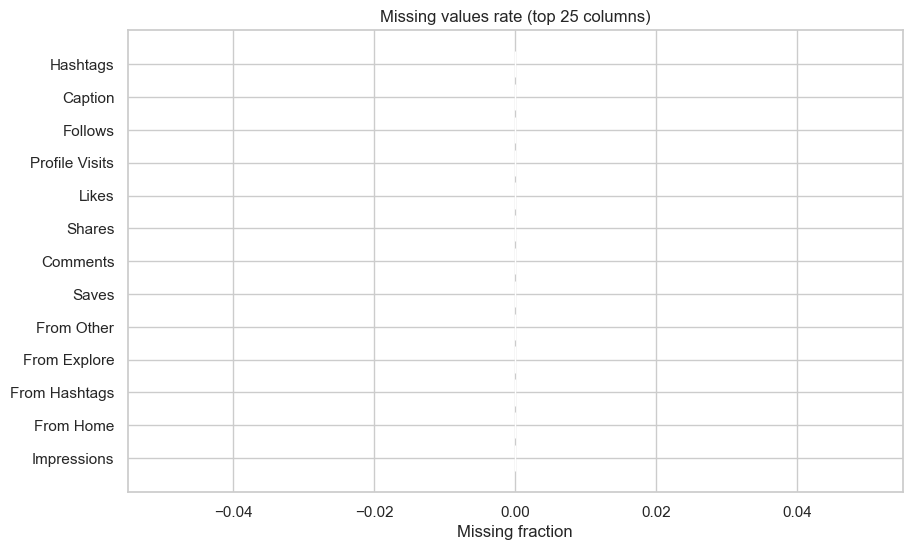

In [110]:
# Missingness plot (top 25 columns)
top_missing = missing.head(25).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(top_missing.index, top_missing.values)
plt.title("Missing values rate (top 25 columns)")
plt.xlabel("Missing fraction")
plt.show()

## 3) Target Definition & Feature Engineering

This section creates the binary target label `Viral` using a top-quantile threshold on **Impressions** (set in the configuration). It also engineers features that commonly explain post reach and conversion, such as:

- **Engagement** = Likes + Comments + Shares
- **Engagement rate** = Engagement / Impressions
- **Visit rate** = Profile Visits / Impressions
- **Follow rate** = Follows / Profile Visits
- Optional text features (caption length, hashtag count) and traffic-source ratios when those columns exist

The goal is to transform raw analytics into comparable, scale-free signals that generalize better than raw counts alone.

In [111]:
df_fe = df.copy()

# Standard numeric columns used in many Instagram exports
maybe_numeric = [
    "Likes", "Comments", "Shares", "Impressions", "Profile Visits", "Follows",
    "From Home", "From Explore", "From Hashtags", "From Other"
 ]
for c in maybe_numeric:
    if _col_exists(df_fe, c):
        df_fe[c] = pd.to_numeric(df_fe[c], errors="coerce")

# Engagement metrics
if all(_col_exists(df_fe, c) for c in ["Likes", "Comments", "Shares"]):
    df_fe["Engagement"] = df_fe["Likes"].fillna(0) + df_fe["Comments"].fillna(0) + df_fe["Shares"].fillna(0)

if _col_exists(df_fe, "Engagement") and _col_exists(df_fe, "Impressions"):
    df_fe["Engagement_Rate"] = safe_divide(df_fe["Engagement"], df_fe["Impressions"])

if _col_exists(df_fe, "Profile Visits") and _col_exists(df_fe, "Impressions"):
    df_fe["Visit_Rate"] = safe_divide(df_fe["Profile Visits"], df_fe["Impressions"])

if _col_exists(df_fe, "Follows") and _col_exists(df_fe, "Profile Visits"):
    df_fe["Follow_Rate"] = safe_divide(df_fe["Follows"], df_fe["Profile Visits"])

# Caption / hashtag simple features
if _col_exists(df_fe, CAPTION_COL):
    df_fe["Caption_Length"] = df_fe[CAPTION_COL].astype(str).str.len()

if _col_exists(df_fe, HASHTAGS_COL):
    # count '#' occurrences; robust to NaN
    df_fe["Hashtag_Count"] = df_fe[HASHTAGS_COL].fillna("").astype(str).str.count(r"#")

# Source ratios (if present)
source_cols = [c for c in ["From Home", "From Explore", "From Hashtags", "From Other"] if _col_exists(df_fe, c)]
if source_cols and _col_exists(df_fe, "Impressions"):
    for c in source_cols:
        df_fe[f"{c}_Ratio"] = safe_divide(df_fe[c], df_fe["Impressions"])

# Create binary target
df_fe, viral_threshold = make_viral_target(df_fe, IMPRESSION_COL, VIRAL_QUANTILE)
print(f"Viral threshold (q={VIRAL_QUANTILE}): {viral_threshold:,.2f}")
display(df_fe[[IMPRESSION_COL, TARGET_COL]].head())

Viral threshold (q=0.9): 10,386.00


,Impressions,Viral
0,3920,False
1,5394,False
2,4021,False
3,4528,False
4,2518,False


Viral
False    108
True      11
Name: count, dtype: int64

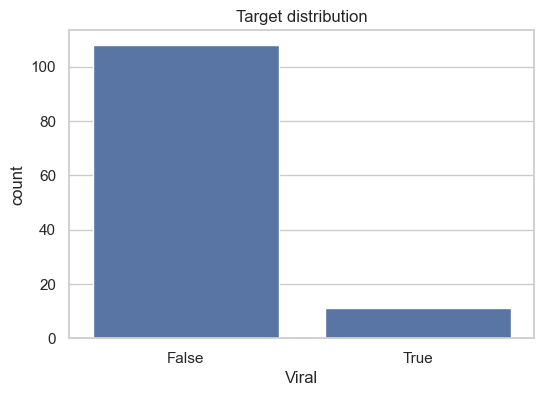

Viral rate: 0.09243697478991597


In [112]:
# Target distribution
target_counts = df_fe[TARGET_COL].value_counts(dropna=False)
display(target_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x=TARGET_COL, data=df_fe)
plt.title("Target distribution")
plt.show()

print("Viral rate:", float(df_fe[TARGET_COL].mean()))

## 4) Exploratory Data Analysis (EDA)

EDA is used to understand the data generating process and validate assumptions before modeling. The analysis focuses on:

- Distributions and skew in key metrics
- Potential outliers and heavy tails (common in social reach data)
- Correlations among metrics and engineered rates
- Differences between viral vs non-viral posts
- Optional quick looks at captions/hashtags when present

In [113]:
# Separate numeric vs categorical columns
numeric_cols = df_fe.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_fe.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
print("Categorical/text columns:", categorical_cols)

Numeric columns: ['Impressions', 'From Home', 'From Hashtags', 'From Explore', 'From Other', 'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits', 'Follows', 'Engagement', 'Engagement_Rate', 'Visit_Rate', 'Follow_Rate', 'Caption_Length', 'Hashtag_Count', 'From Home_Ratio', 'From Explore_Ratio', 'From Hashtags_Ratio', 'From Other_Ratio']
Categorical/text columns: ['Caption', 'Hashtags', 'Viral']


In [114]:
# Summary stats for numeric columns
display(df_fe[numeric_cols].describe().T.sort_values("mean", ascending=False).head(30))

,count,mean,std,min,25%,50%,75%,max
Impressions,119.0,5703.991597,4843.780105,1941.000000,3467.000000,4289.000000,6138.000000,36919.000000
From Home,119.0,2475.789916,1489.386348,1133.000000,1945.000000,2207.000000,2602.500000,13473.000000
From Hashtags,119.0,1887.512605,1884.361443,116.000000,726.000000,1278.000000,2363.500000,11817.000000
From Explore,119.0,1078.100840,2613.026132,0.000000,157.500000,326.000000,689.500000,17414.000000
Caption_Length,119.0,192.462185,141.756044,44.000000,90.500000,156.000000,235.000000,784.000000
Engagement,119.0,189.806723,90.280568,75.000000,130.500000,171.000000,222.000000,626.000000
Likes,119.0,173.781513,82.378947,72.000000,121.500000,151.000000,204.000000,549.000000
From Other,119.0,171.092437,289.431031,9.000000,38.000000,74.000000,196.000000,2547.000000
Saves,119.0,153.310924,156.317731,22.000000,65.000000,109.000000,169.000000,1095.000000
Profile Visits,119.0,50.621849,87.088402,4.000000,15.000000,23.000000,42.000000,611.000000


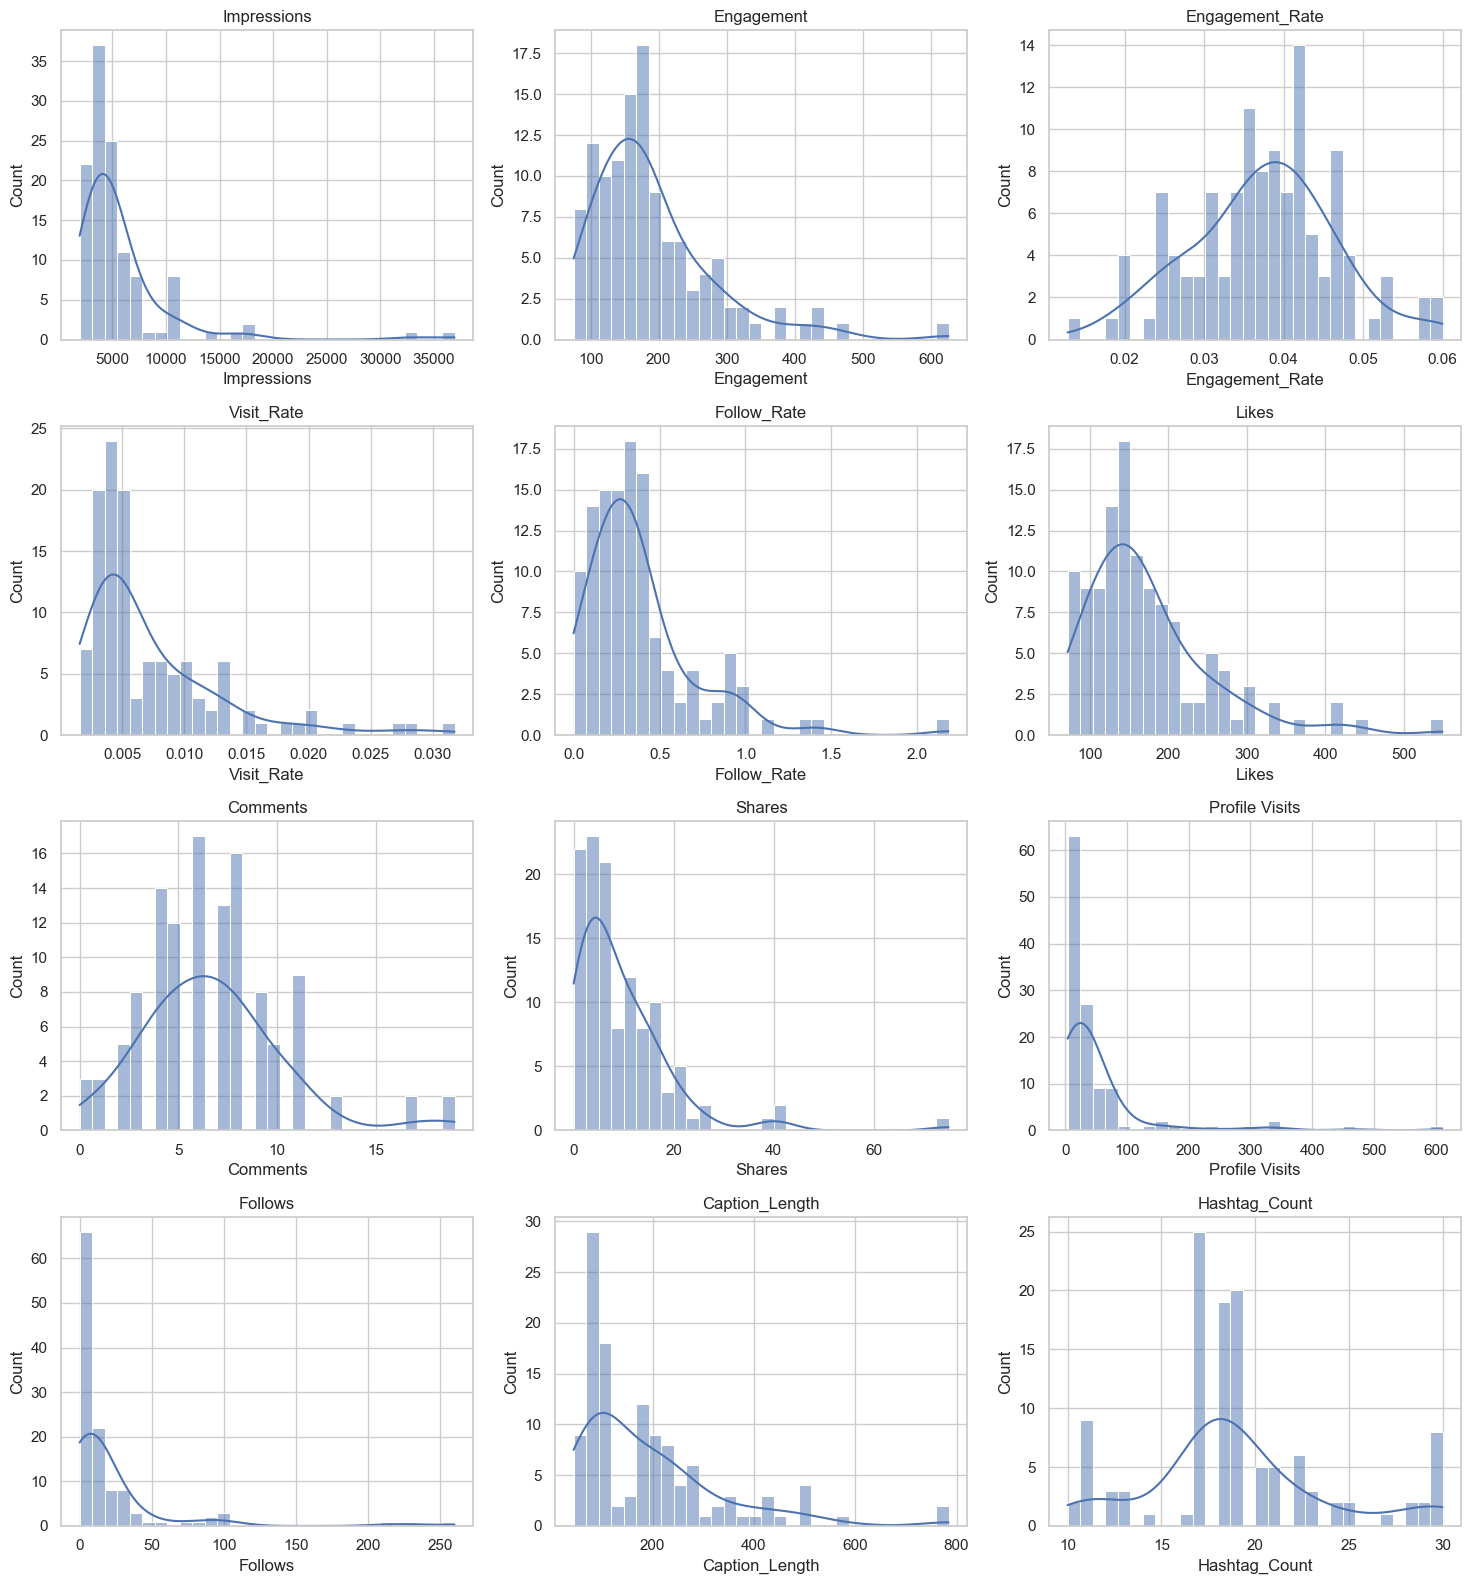

In [115]:
# Distribution plots for key metrics (auto-select if present)
key_metrics = [
    "Impressions", "Engagement", "Engagement_Rate", "Visit_Rate", "Follow_Rate",
    "Likes", "Comments", "Shares", "Profile Visits", "Follows", "Caption_Length", "Hashtag_Count"
 ]
key_metrics = [c for c in key_metrics if c in df_fe.columns]

n = len(key_metrics)
if n == 0:
    print("No known key metrics found; adjust key_metrics list.")
else:
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = np.array(axes).reshape(rows, cols)
    for i, col in enumerate(key_metrics):
        ax = axes[i // cols, i % cols]
        series = pd.to_numeric(df_fe[col], errors="coerce")
        sns.histplot(series, kde=True, ax=ax, bins=30)
        ax.set_title(col)
    for j in range(i + 1, rows * cols):
        axes[j // cols, j % cols].axis("off")
    plt.tight_layout()
    plt.show()

In [116]:
# Outlier scan using IQR (quick heuristic)
def iqr_outlier_fraction(s: pd.Series) -> float:
    s = pd.to_numeric(s, errors="coerce").dropna()
    if len(s) < 10:
        return np.nan
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        return 0.0
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    return float(((s < lo) | (s > hi)).mean())

outlier_report = (
    df_fe[numeric_cols]
      .apply(iqr_outlier_fraction)
      .sort_values(ascending=False)
      .to_frame("outlier_fraction")
 )
display(outlier_report.head(20))

,outlier_fraction
From Other_Ratio,0.142857
From Explore,0.134454
Impressions,0.117647
Hashtag_Count,0.117647
Follows,0.109244
Follow_Rate,0.109244
From Explore_Ratio,0.109244
From Other,0.092437
Profile Visits,0.092437
Saves,0.084034


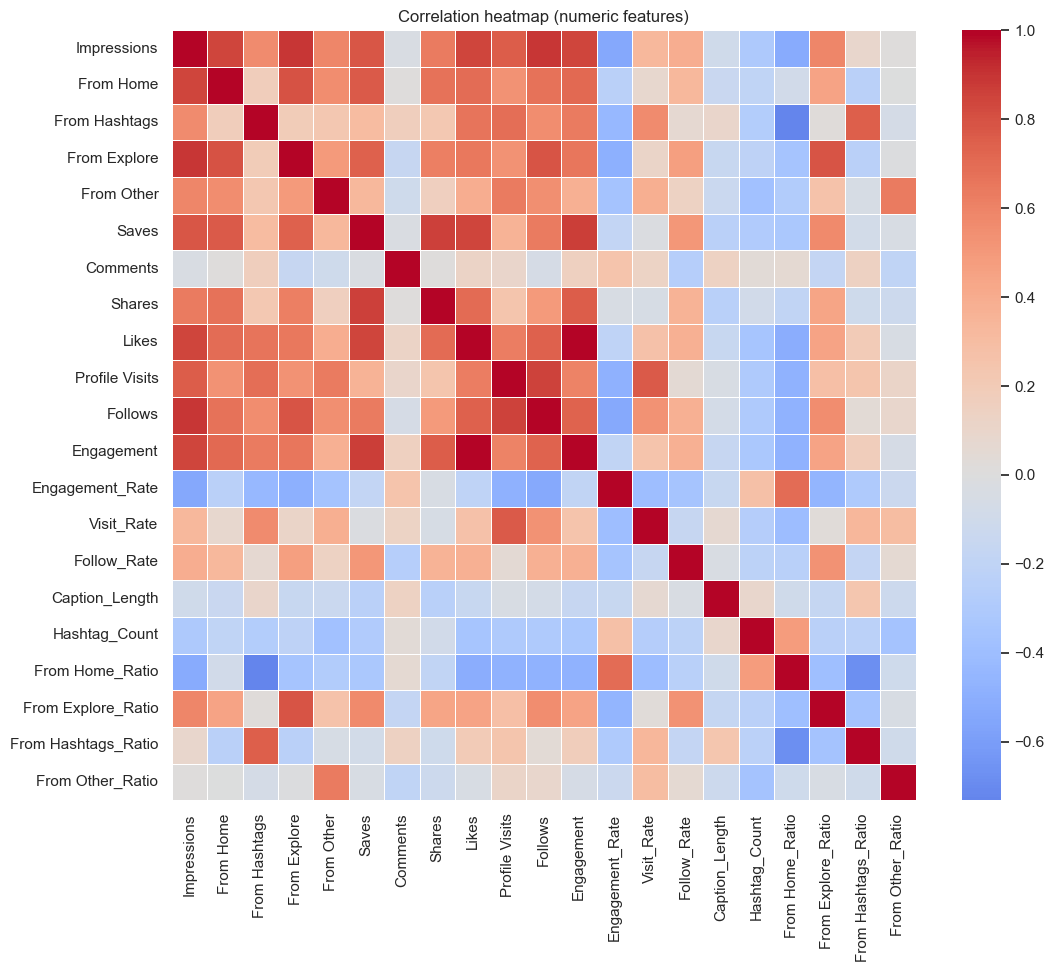

In [117]:
# Correlation heatmap (numeric)
corr = df_fe[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation heatmap (numeric features)")
plt.show()

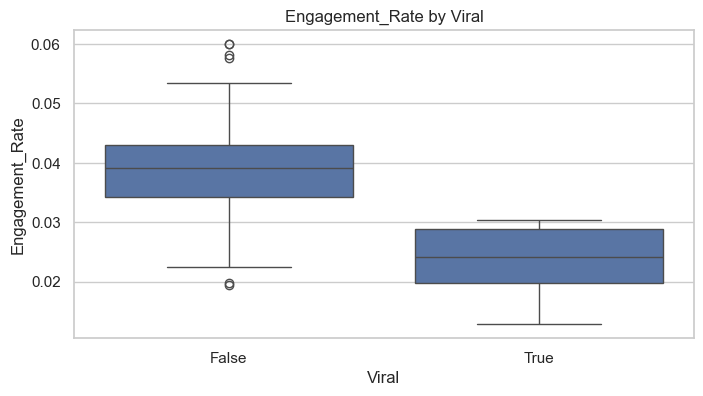

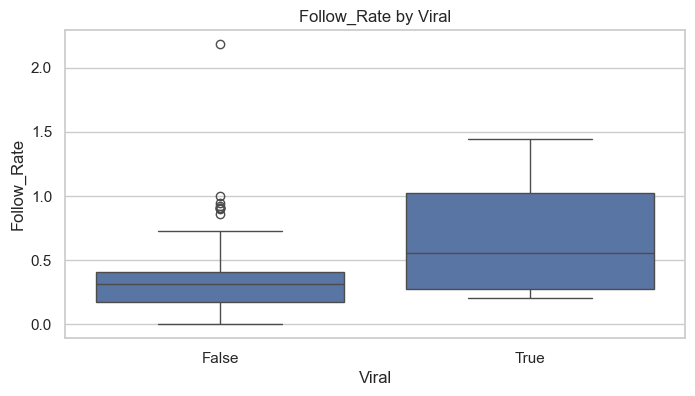

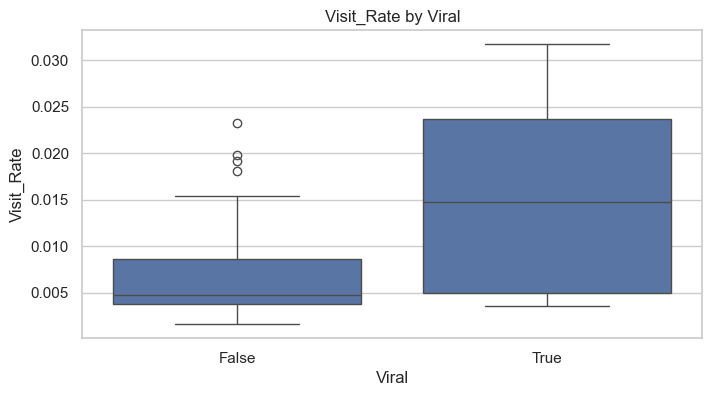

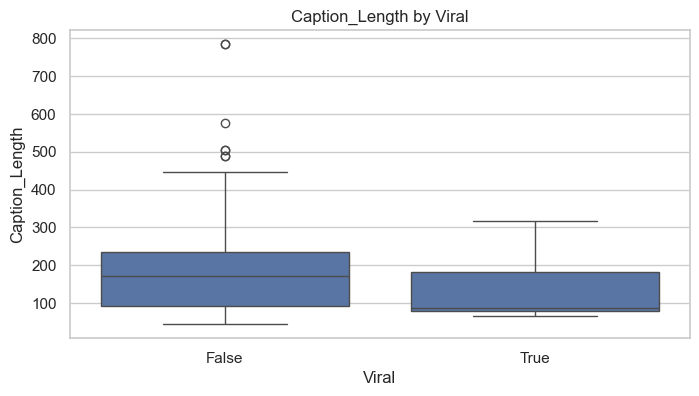

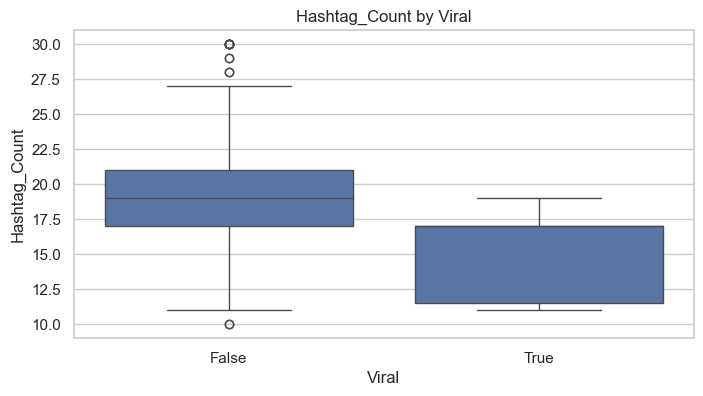

In [118]:
# Compare distributions by target for selected numeric features
compare_cols = [c for c in ["Engagement_Rate", "Follow_Rate", "Visit_Rate", "Caption_Length", "Hashtag_Count"] if c in df_fe.columns]
if compare_cols:
    for c in compare_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=TARGET_COL, y=c, data=df_fe)
        plt.title(f"{c} by {TARGET_COL}")
        plt.show()
else:
    print("No compare_cols found in dataset; adjust list.")

In [119]:
# Optional: quick text sanity checks
if _col_exists(df_fe, CAPTION_COL):
    print("Caption examples:")
    display(df_fe[CAPTION_COL].dropna().astype(str).sample(min(5, df_fe[CAPTION_COL].dropna().shape[0]), random_state=RANDOM_STATE))

if _col_exists(df_fe, HASHTAGS_COL):
    print("Hashtag examples:")
    display(df_fe[HASHTAGS_COL].dropna().astype(str).sample(min(5, df_fe[HASHTAGS_COL].dropna().shape[0]), random_state=RANDOM_STATE))

Caption examples:


56    Here are some of the best data science project...
89    Here are some of the most important machine le...
4     Plotting annotations while visualizing your da...
45    Here are some of the best Python project ideas...
26    You must have heard or invested in any cryptoc...
Name: Caption, dtype: object

Hashtag examples:


56    #recommended #recommendations #recommendations...
89    #data #datascience #dataanalysis #dataanalytic...
4     #datavisualization #datascience #data #dataana...
45    #python #pythonprogramming #pythonprojects #py...
26    #data #datascience #dataanalysis #dataanalytic...
Name: Hashtags, dtype: object

## 5) Modeling Approach (Preprocessing Pipelines)

Modeling is implemented with scikit-learn `Pipeline` + `ColumnTransformer` so preprocessing is applied consistently and leakage is avoided. The pipeline structure is:

1. Train/test split with stratification
2. Numeric preprocessing (imputation + scaling)
3. Categorical preprocessing (imputation + one-hot encoding)
4. Optional text preprocessing (TF‑IDF) when caption/hashtags exist
5. Classifier training and evaluation

This approach mirrors how the model would be used in a real workflow: raw rows in, predictions out.

In [120]:
# Prepare X/y
df_model = df_fe.copy()

# Drop rows without target (should be none, but safe)
df_model = df_model.dropna(subset=[TARGET_COL])

y = df_model[TARGET_COL].astype(int)  # 0/1
X = df_model.drop(columns=[TARGET_COL])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
 )
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train viral rate:", y_train.mean(), "Test viral rate:", y_test.mean())

Train shape: (95, 23) Test shape: (24, 23)
Train viral rate: 0.09473684210526316 Test viral rate: 0.08333333333333333


In [121]:
# Build a single combined text field (Caption + Hashtags) if present
def build_text_feature(df: pd.DataFrame) -> pd.Series:
    parts = []
    if CAPTION_COL in df.columns:
        parts.append(df[CAPTION_COL].fillna("").astype(str))
    if HASHTAGS_COL in df.columns:
        parts.append(df[HASHTAGS_COL].fillna("").astype(str))
    if not parts:
        return pd.Series([""] * len(df), index=df.index)
    return (parts[0] if len(parts) == 1 else (parts[0] + " " + parts[1])).str.strip()

X_train2 = X_train.copy()
X_test2 = X_test.copy()

if SKLEARN_TEXT_OK and (CAPTION_COL in X_train2.columns or HASHTAGS_COL in X_train2.columns):
    X_train2["__text__"] = build_text_feature(X_train2)
    X_test2["__text__"] = build_text_feature(X_test2)
else:
    # Still create a placeholder to keep pipeline consistent
    X_train2["__text__"] = ""
    X_test2["__text__"] = ""

X_train2.columns[:10], X_train2.shape

(Index(['Impressions', 'From Home', 'From Hashtags', 'From Explore',
        'From Other', 'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits'],
       dtype='object'),
 (95, 24))

In [122]:
# Define feature groups
all_cols = X_train2.columns.tolist()
text_col = "__text__"

numeric_features = [c for c in all_cols if c != text_col and pd.api.types.is_numeric_dtype(X_train2[c])]
categorical_features = [c for c in all_cols if c != text_col and c not in numeric_features]

print("Numeric feature count:", len(numeric_features))
print("Categorical feature count:", len(categorical_features))
print("Text feature included:", text_col in all_cols)

numeric_features[:10], categorical_features[:10]

Numeric feature count: 21
Categorical feature count: 2
Text feature included: True


(['Impressions',
  'From Home',
  'From Hashtags',
  'From Explore',
  'From Other',
  'Saves',
  'Comments',
  'Shares',
  'Likes',
  'Profile Visits'],
 ['Caption', 'Hashtags'])

In [123]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

# Text handling: only enable TF-IDF when real text columns exist; otherwise drop the placeholder
USE_TEXT = SKLEARN_TEXT_OK and (CAPTION_COL in X_train2.columns or HASHTAGS_COL in X_train2.columns)
text_columns = [text_col]  # pass as a 1-column DataFrame (2D) to keep imputers happy

if USE_TEXT:
    text_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="")),
        ("to_1d", FunctionTransformer(lambda x: np.asarray(x).ravel(), feature_names_out="one-to-one")),
        ("tfidf", TfidfVectorizer(
            max_features=25_000,
            ngram_range=(1, 2),
            min_df=2
        )),
    ])
else:
    text_transformer = "drop"

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", text_transformer, text_columns),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Impressions', 'From Home', 'From Hashtags',
                                  'From Explore', 'From Other', 'Saves',
                                  'Comments', 'Shares', 'Likes',
                                  'Profile Visits', 'Follows', 'Engagement',
                                  'Engagement_Rate', 'Visit_Rate',
                                  'Follow_Rate', 'Caption_Length',
                                  'Hashtag_Count',...
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Caption', 'Hashtags']),
                                ('txt',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='',
                                                                strategy='constant')),
                                                 ('to_1d',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x00000217386D9C60>)),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=25000,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2)))]),
                                 ['__text__'])])

In [124]:
# Evaluation helpers
def get_score_vector(model, X) -> np.ndarray:
    """Return a continuous score for ROC/PR curves."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    # fallback: hard predictions (not ideal for AUC)
    return model.predict(X)

def evaluate_on_holdout(pipeline: Pipeline, X_tr, y_tr, X_te, y_te, name: str) -> Dict[str, Any]:
    pipeline.fit(X_tr, y_tr)
    preds = pipeline.predict(X_te)
    scores = get_score_vector(pipeline, X_te)

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_te, preds),
        "balanced_accuracy": balanced_accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds, zero_division=0),
        "recall": recall_score(y_te, preds, zero_division=0),
        "f1": f1_score(y_te, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_te, scores),
        "pr_auc": average_precision_score(y_te, scores),
    }
    return metrics

def plot_confusion(pipeline: Pipeline, X_te, y_te, title: str):
    preds = pipeline.predict(X_te)
    cm = confusion_matrix(y_te, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()

def plot_roc_pr(pipeline: Pipeline, X_te, y_te, title_prefix: str):
    scores = get_score_vector(pipeline, X_te)
    fpr, tpr, _ = roc_curve(y_te, scores)
    prec, rec, _ = precision_recall_curve(y_te, scores)
    roc_auc = roc_auc_score(y_te, scores)
    pr_auc = average_precision_score(y_te, scores)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
    axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"{title_prefix} — ROC")
    axes[0].legend()

    axes[1].plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title(f"{title_prefix} — Precision-Recall")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

## 6) Baselines & Model Comparison

Multiple models are trained and compared to establish a strong, defensible baseline:

- `DummyClassifier` (sanity check baseline)
- Logistic Regression (interpretable linear baseline)
- Random Forest (non-linear, robust)
- HistGradientBoosting (strong tabular learner)

Performance is reported on a held-out test set, with ROC/PR curves to visualize the trade-offs between catching viral posts and avoiding false positives.

In [125]:
models = {
    "dummy_most_frequent": DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE),
    "logreg": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear",
        random_state=RANDOM_STATE,
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=500,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1,
    ),
    "hist_gbdt": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
}

results = []
fitted_pipelines: Dict[str, Pipeline] = {}

# HistGradientBoosting requires dense input; one-hot/TF-IDF often yields sparse matrices.
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else np.asarray(x),
    accept_sparse=True,
    feature_names_out="one-to-one",
)

for name, clf in models.items():
    steps = [("prep", preprocess)]
    if name == "hist_gbdt":
        steps.append(("to_dense", to_dense))
    steps.append(("clf", clf))

    pipe = Pipeline(steps=steps)
    m = evaluate_on_holdout(pipe, X_train2, y_train, X_test2, y_test, name=name)
    results.append(m)
    fitted_pipelines[name] = pipe

results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
display(results_df)

,model,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,pr_auc
3,hist_gbdt,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000
1,logreg,0.958333,0.977273,0.666667,1.0,0.8,0.977273,0.833333
2,random_forest,0.916667,0.500000,0.000000,0.0,0.0,0.954545,0.750000
0,dummy_most_frequent,0.916667,0.500000,0.000000,0.0,0.0,0.500000,0.083333


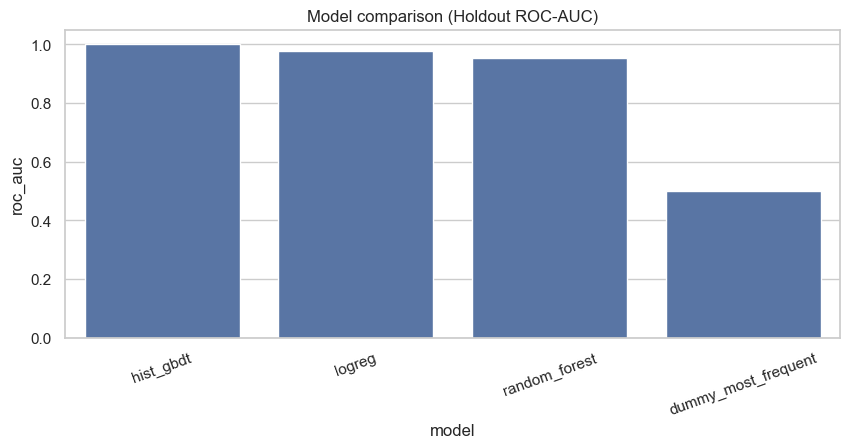

In [126]:
# Visual comparison
plt.figure(figsize=(10, 4))
sns.barplot(data=results_df, x="model", y="roc_auc")
plt.xticks(rotation=20)
plt.title("Model comparison (Holdout ROC-AUC)")
plt.show()

Best model (holdout ROC-AUC): hist_gbdt


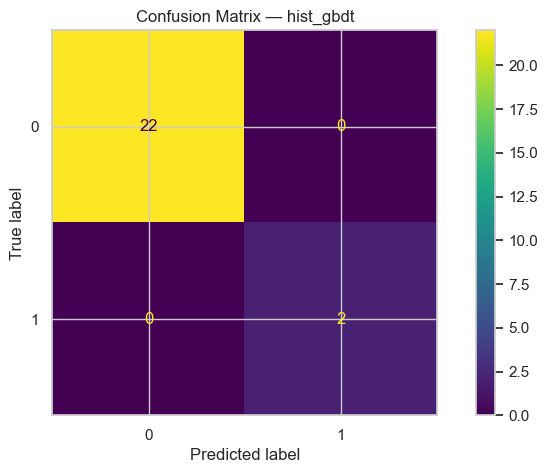

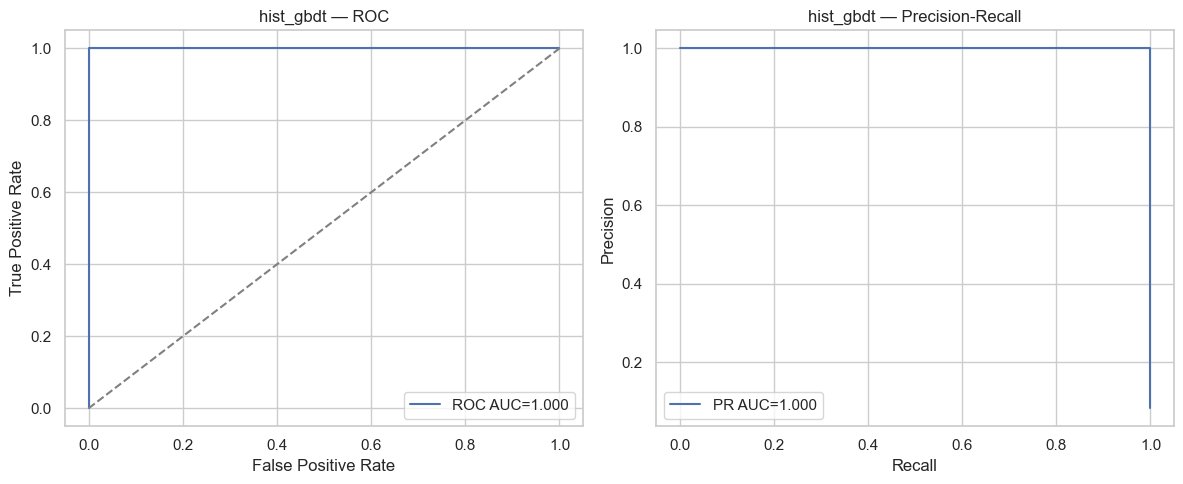

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        22
           1      1.000     1.000     1.000         2

    accuracy                          1.000        24
   macro avg      1.000     1.000     1.000        24
weighted avg      1.000     1.000     1.000        24



In [127]:
# Pick the current best by holdout ROC-AUC (you can override manually)
best_name = results_df.iloc[0]["model"]
best_pipe = fitted_pipelines[best_name]
print("Best model (holdout ROC-AUC):", best_name)

plot_confusion(best_pipe, X_test2, y_test, title=f"Confusion Matrix — {best_name}")
plot_roc_pr(best_pipe, X_test2, y_test, title_prefix=best_name)

print(classification_report(y_test, best_pipe.predict(X_test2), digits=3))

### Cross-Validation (Stability Check)

A single train/test split can be noisy, especially with smaller datasets. Cross-validation provides a more stable estimate by evaluating each model across multiple folds and summarizing mean and variance for key metrics.

In [128]:
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "balanced_acc": "balanced_accuracy",
}

# HistGradientBoosting requires dense input; one-hot/TF-IDF often yields sparse matrices.
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else np.asarray(x),
    accept_sparse=True,
    feature_names_out="one-to-one",
)

cv_rows = []
for name, clf in models.items():
    steps = [("prep", preprocess)]
    if name == "hist_gbdt":
        steps.append(("to_dense", to_dense))
    steps.append(("clf", clf))
    pipe = Pipeline(steps=steps)

    cv_out = cross_validate(
        pipe, X_train2, y_train,
        cv=cv, scoring=scoring, n_jobs=-1, error_score="raise"
    )
    row = {"model": name}
    for k, v in cv_out.items():
        if k.startswith("test_"):
            metric = k.replace("test_", "")
            row[f"{metric}_mean"] = float(np.mean(v))
            row[f"{metric}_std"] = float(np.std(v))
    cv_rows.append(row)

cv_df = pd.DataFrame(cv_rows).sort_values("roc_auc_mean", ascending=False)
display(cv_df)

,model,roc_auc_mean,roc_auc_std,avg_precision_mean,avg_precision_std,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std,balanced_acc_mean,balanced_acc_std
1,logreg,1.0,0.0,1.000000,0.000000,0.786667,0.122202,0.766667,0.20000,0.9,0.2,0.932680,0.092023
2,random_forest,1.0,0.0,1.000000,0.000000,0.666667,0.365148,0.700000,0.40000,0.7,0.4,0.844444,0.196104
3,hist_gbdt,1.0,0.0,1.000000,0.000000,0.693333,0.369023,0.733333,0.38873,0.7,0.4,0.844118,0.195892
0,dummy_most_frequent,0.5,0.0,0.094737,0.021053,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.500000,0.000000


## 7) Hyperparameter Tuning (Randomized Search)

After selecting a strong candidate model, randomized search is used to explore a bounded hyperparameter space and improve performance without excessive compute. The search budget is intentionally limited so the notebook remains practical to run end-to-end.

In [129]:
# Choose a model to tune based on CV ranking (override if you want)
cv_best_name = cv_df.iloc[0]["model"]
print("Best model by CV ROC-AUC:", cv_best_name)

tune_target = cv_best_name

if tune_target == "logreg":
    base_clf = LogisticRegression(max_iter=4000, class_weight="balanced", solver="liblinear", random_state=RANDOM_STATE)
    param_distributions = {
        "clf__C": np.logspace(-3, 3, 30),
        "clf__penalty": ["l1", "l2"],
    }
elif tune_target == "random_forest":
    base_clf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced_subsample", n_jobs=-1)
    param_distributions = {
        "clf__n_estimators": [200, 400, 800, 1200],
        "clf__max_depth": [None, 5, 10, 20, 30],
        "clf__min_samples_split": [2, 5, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4, 8],
        "clf__max_features": ["sqrt", "log2", None],
    }
else:
    # HistGradientBoosting default tuning
    base_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    param_distributions = {
        "clf__max_depth": [None, 3, 5, 8],
        "clf__learning_rate": np.linspace(0.01, 0.3, 20),
        "clf__max_iter": [200, 400, 800],
        "clf__min_samples_leaf": [10, 20, 50, 100],
    }

# HistGradientBoosting requires dense input; one-hot/TF-IDF often yields sparse matrices.
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else np.asarray(x),
    accept_sparse=True,
    feature_names_out="one-to-one",
)

tune_steps = [("prep", preprocess)]
if tune_target == "hist_gbdt":
    tune_steps.append(("to_dense", to_dense))
tune_steps.append(("clf", base_clf))
tune_pipe = Pipeline(steps=tune_steps)

search = RandomizedSearchCV(
    estimator=tune_pipe,
    param_distributions=param_distributions,
    n_iter=N_RANDOM_SEARCH_ITERS,
    scoring="roc_auc",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=N_RANDOM_SEARCH_JOBS,
    verbose=1,
)

search.fit(X_train2, y_train)
print("Best CV ROC-AUC:", search.best_score_)
search.best_params_

Best model by CV ROC-AUC: logreg
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV ROC-AUC: 1.0


{'clf__penalty': 'l2', 'clf__C': np.float64(0.002592943797404667)}

,model,accuracy,balanced_accuracy,precision,recall,f1,roc_auc,pr_auc
0,tuned,0.75,0.863636,0.25,1.0,0.4,0.954545,0.75


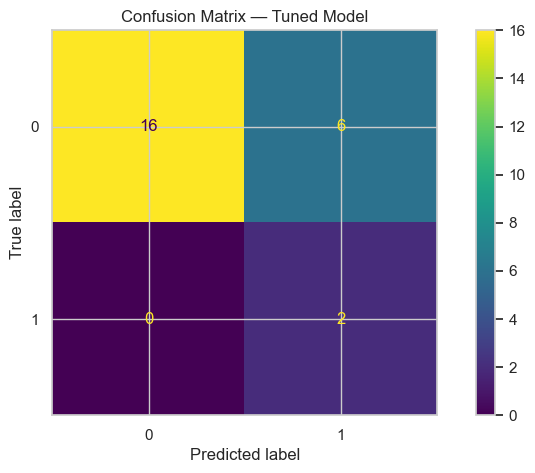

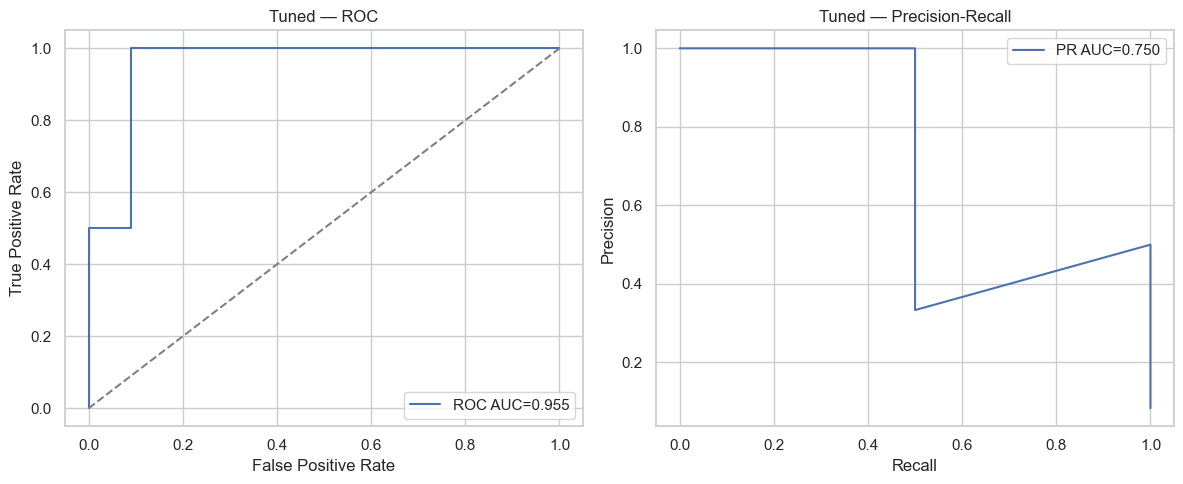

              precision    recall  f1-score   support

           0      1.000     0.727     0.842        22
           1      0.250     1.000     0.400         2

    accuracy                          0.750        24
   macro avg      0.625     0.864     0.621        24
weighted avg      0.938     0.750     0.805        24



In [130]:
# Evaluate tuned model on holdout
best_tuned = search.best_estimator_
tuned_metrics = evaluate_on_holdout(best_tuned, X_train2, y_train, X_test2, y_test, name="tuned")
display(pd.DataFrame([tuned_metrics]))

plot_confusion(best_tuned, X_test2, y_test, title="Confusion Matrix — Tuned Model")
plot_roc_pr(best_tuned, X_test2, y_test, title_prefix="Tuned")
print(classification_report(y_test, best_tuned.predict(X_test2), digits=3))

## 8) Model Interpretation

To understand which inputs most influence predictions, this notebook uses **permutation importance** on the full pipeline. This method measures how much model performance drops when a feature is randomly shuffled, and it works across different model families while respecting preprocessing.

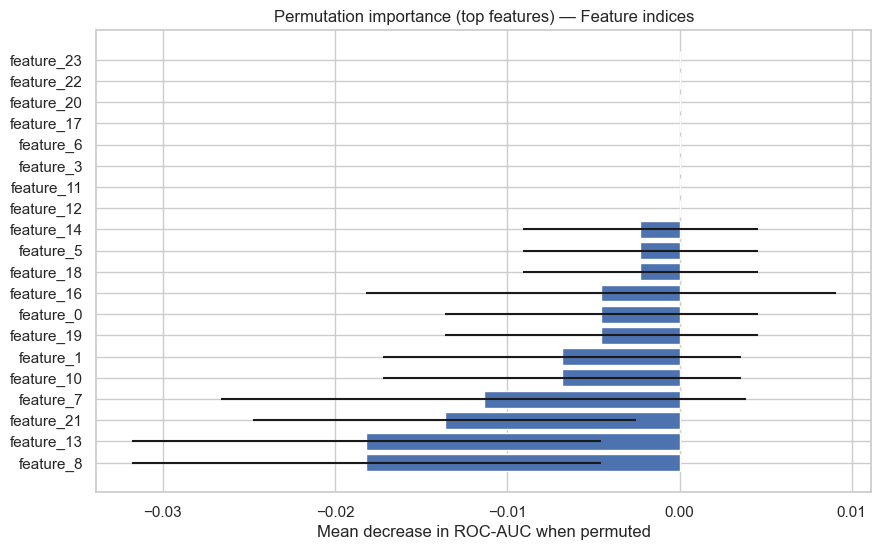

Note: feature indices map to the transformed feature space (after one-hot/TF-IDF).


In [131]:
# Permutation importance on a sample (can be slow on large datasets)
sample_size = min(500, len(X_test2))
X_pi = X_test2.sample(sample_size, random_state=RANDOM_STATE)
y_pi = y_test.loc[X_pi.index]

pi = permutation_importance(
    best_tuned, X_pi, y_pi,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
 )

importances = pd.Series(pi.importances_mean)
importances_std = pd.Series(pi.importances_std)

top_k = 20
top_idx = np.argsort(importances.values)[-top_k:][::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), importances.iloc[top_idx][::-1], xerr=importances_std.iloc[top_idx][::-1])
plt.yticks(range(top_k), [f"feature_{i}" for i in top_idx][::-1])
plt.title("Permutation importance (top features) — Feature indices")
plt.xlabel("Mean decrease in ROC-AUC when permuted")
plt.show()

print("Note: feature indices map to the transformed feature space (after one-hot/TF-IDF).")

## 9) Error Analysis (Where Predictions Fail)

Error analysis reviews false positives and false negatives to understand common failure modes. This can reveal:

- Ambiguous examples near the decision boundary
- Missing or mis-typed fields
- Feature gaps (signals the model can’t see yet)
- Opportunities to redefine the target or add context (e.g., post type, timing)

In [132]:
preds = best_tuned.predict(X_test2)
scores = get_score_vector(best_tuned, X_test2)

err_df = X_test2.copy()
err_df["y_true"] = y_test.values
err_df["y_pred"] = preds
err_df["score"] = scores

fp = err_df[(err_df["y_true"] == 0) & (err_df["y_pred"] == 1)].sort_values("score", ascending=False)
fn = err_df[(err_df["y_true"] == 1) & (err_df["y_pred"] == 0)].sort_values("score", ascending=True)

cols_to_show = [c for c in [IMPRESSION_COL, "Engagement", "Engagement_Rate", "Follow_Rate", "Visit_Rate", "Hashtag_Count", "Caption_Length", CAPTION_COL, HASHTAGS_COL] if c in err_df.columns]
cols_to_show = cols_to_show + ["y_true", "y_pred", "score"]

print("False Positives (top 10):")
display(fp[cols_to_show].head(10))

print("False Negatives (top 10):")
display(fn[cols_to_show].head(10))

False Positives (top 10):


,Impressions,Engagement,Engagement_Rate,Follow_Rate,Visit_Rate,Hashtag_Count,Caption_Length,Caption,Hashtags,y_true,y_pred,score
90,10386,377,0.036299,0.904762,0.004044,17,91,Here are some of the best websites that you ca...,#data #datascience #dataanalysis #dataanalytic...,0,1,0.669238
14,9453,310,0.032794,0.232044,0.019147,19,60,Omicron Variant Sentiment Analysis using Pytho...,#data #datascience #dataanalysis #dataanalytic...,0,1,0.636221
108,6814,279,0.040945,0.666667,0.003522,17,91,Here are some of the best websites that you ca...,#datascience #datasciencejobs #datasciencetrai...,0,1,0.563644
74,6559,271,0.041317,0.545455,0.003354,18,187,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...,0,1,0.527260
1,5394,245,0.045421,0.208333,0.008899,18,187,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...,0,1,0.507996
53,6432,231,0.035914,0.181818,0.003420,17,92,Here are some of the best data science project...,#data #datascience #dataanalysis #dataanalytic...,0,1,0.502559


False Negatives (top 10):


,Impressions,Engagement,Engagement_Rate,Follow_Rate,Visit_Rate,Hashtag_Count,Caption_Length,Caption,Hashtags,y_true,y_pred,score


## 10) Decision Threshold (Optional)

Classification performance depends on the decision threshold. Instead of always using 0.5, the threshold can be adjusted based on the goal:

- Higher threshold → fewer “viral” predictions (typically higher precision)
- Lower threshold → more “viral” predictions (typically higher recall)

The plots below show the precision/recall/F1 trade-off across thresholds.

,value
threshold,0.564184
precision,0.500000
recall,1.000000
f1,0.666667


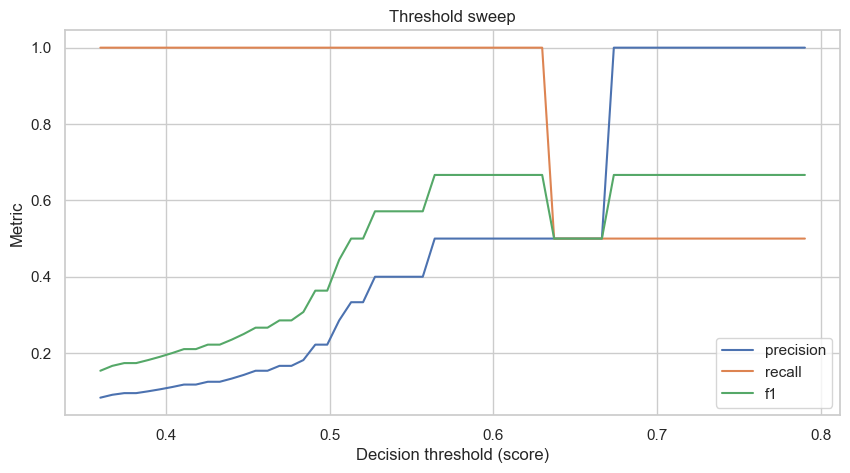

In [133]:
# Sweep thresholds and show precision/recall/F1 tradeoff
scores = get_score_vector(best_tuned, X_test2)
thresholds = np.linspace(np.min(scores), np.max(scores), 60)
rows = []
for t in thresholds:
    p = (scores >= t).astype(int)
    rows.append({
        "threshold": float(t),
        "precision": precision_score(y_test, p, zero_division=0),
        "recall": recall_score(y_test, p, zero_division=0),
        "f1": f1_score(y_test, p, zero_division=0),
    })
thr_df = pd.DataFrame(rows)
best_f1_row = thr_df.iloc[thr_df["f1"].idxmax()]
display(best_f1_row.to_frame("value"))

plt.figure(figsize=(10, 5))
plt.plot(thr_df["threshold"], thr_df["precision"], label="precision")
plt.plot(thr_df["threshold"], thr_df["recall"], label="recall")
plt.plot(thr_df["threshold"], thr_df["f1"], label="f1")
plt.title("Threshold sweep")
plt.xlabel("Decision threshold (score)")
plt.ylabel("Metric")
plt.legend()
plt.show()

## 13) Conclusions & Next Steps

This notebook demonstrates an end-to-end workflow for viral-post prediction: defining a data-driven target, validating the dataset, engineering meaningful engagement features, training multiple models, and exporting a reusable pipeline artifact.

**Potential extensions (project roadmap)**
- Use time-based validation if a post timestamp is available
- Add richer content features (topics, sentiment, emoji/formatting signals)
- Handle class imbalance more explicitly (calibration, reweighting, resampling)
- Compare additional models (e.g., gradient boosting libraries) where permitted
- Package inference into a small script or API for repeatable scoring pipelines